In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import rasterio as rio
import rioxarray
import math

import crunchy_snow.models
import crunchy_snow.dataset
from crunchy_snow.utils import calc_norm, undo_norm

In [2]:
data_fn = '../../data/application_tmp/RMNP.nc'
ds = xr.open_dataset(data_fn)

In [3]:
ds = ds.fillna(0)

In [4]:
data_dict = {}

In [5]:
# normalize layers 
data_dict['snowon_vv'] = calc_norm(torch.Tensor(ds['snowon_vv'].values), crunchy_snow.dataset.norm_dict['vv'])
data_dict['snowon_vh'] = calc_norm(torch.Tensor(ds['snowon_vh'].values), crunchy_snow.dataset.norm_dict['vh'])
data_dict['snowoff_vv'] = calc_norm(torch.Tensor(ds['snowoff_vv'].values), crunchy_snow.dataset.norm_dict['vv'])
data_dict['snowoff_vh'] = calc_norm(torch.Tensor(ds['snowoff_vh'].values), crunchy_snow.dataset.norm_dict['vh'])
data_dict['aerosol_optical_thickness'] = calc_norm(torch.Tensor(ds['AOT'].values), crunchy_snow.dataset.norm_dict['AOT'])
data_dict['coastal_aerosol'] = calc_norm(torch.Tensor(ds['B01'].values), crunchy_snow.dataset.norm_dict['coastal'])
data_dict['blue'] = calc_norm(torch.Tensor(ds['B02'].values), crunchy_snow.dataset.norm_dict['blue'])
data_dict['green'] = calc_norm(torch.Tensor(ds['B03'].values), crunchy_snow.dataset.norm_dict['green'])
data_dict['red'] = calc_norm(torch.Tensor(ds['B04'].values), crunchy_snow.dataset.norm_dict['red'])
data_dict['red_edge1'] = calc_norm(torch.Tensor(ds['B05'].values), crunchy_snow.dataset.norm_dict['red_edge1'])
data_dict['red_edge2'] = calc_norm(torch.Tensor(ds['B06'].values), crunchy_snow.dataset.norm_dict['red_edge2'])
data_dict['red_edge3'] = calc_norm(torch.Tensor(ds['B07'].values), crunchy_snow.dataset.norm_dict['red_edge3'])
data_dict['nir'] = calc_norm(torch.Tensor(ds['B08'].values), crunchy_snow.dataset.norm_dict['nir'])
data_dict['water_vapor'] = calc_norm(torch.Tensor(ds['B09'].values), crunchy_snow.dataset.norm_dict['water_vapor'])
data_dict['swir1'] = calc_norm(torch.Tensor(ds['B11'].values), crunchy_snow.dataset.norm_dict['swir1'])
data_dict['swir2'] = calc_norm(torch.Tensor(ds['B12'].values), crunchy_snow.dataset.norm_dict['swir2'])
data_dict['scene_class_map'] = calc_norm(torch.Tensor(ds['SCL'].values), crunchy_snow.dataset.norm_dict['scene_class_map'])
data_dict['water_vapor_product'] = calc_norm(torch.Tensor(ds['WVP'].values), crunchy_snow.dataset.norm_dict['water_vapor_product'])
data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), crunchy_snow.dataset.norm_dict['elevation'])
data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), crunchy_snow.dataset.norm_dict['latitude'])
data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), crunchy_snow.dataset.norm_dict['longitude'])
# data_dict['dowy'] = calc_norm(torch.Tensor(dowy, [0, 365])
data_dict['ndvi'] = calc_norm(torch.Tensor(ds['ndvi'].values), [-1, 1])
data_dict['ndsi'] = calc_norm(torch.Tensor(ds['ndsi'].values), [-1, 1])
data_dict['ndwi'] = calc_norm(torch.Tensor(ds['ndwi'].values), [-1, 1])
data_dict['snowon_cr'] = calc_norm(torch.Tensor(ds['snowon_cr'].values), crunchy_snow.dataset.norm_dict['cr'])
data_dict['snowoff_cr'] = calc_norm(torch.Tensor(ds['snowoff_cr'].values), crunchy_snow.dataset.norm_dict['cr'])
data_dict['delta_cr'] = calc_norm(torch.Tensor(ds['delta_cr'].values), crunchy_snow.dataset.norm_dict['delta_cr'])

data_dict['fcf'] = torch.Tensor(ds['fcf'].values)

In [6]:
# clamp values, add dimensions
data_dict = {key: torch.clamp(data_dict[key], 0, 1)[None, None, :, :] for key in data_dict.keys()}

In [7]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr']

In [8]:
#load previous model
model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
model.load_state_dict(torch.load('../../weights/quinn_ResDepth_v3'))
model.to('cuda');

In [9]:
tile_size = 1024

xmin=0
xmax=tile_size
ymin=0
ymax=tile_size

inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1)
inputs_pad = F.pad(inputs, (0, tile_size, 0, tile_size), 'constant', 0)

pred_pad = torch.empty_like(inputs_pad[0, 0, :, :])

for i in range(math.ceil((len(ds.x)/tile_size))):
    #print(f'column {i}')
    for j in range(math.ceil((len(ds.y)/tile_size))):
        #print(f'row {j}')
        ymin = j*tile_size
        ymax = (j+1)*tile_size
        xmin = i*tile_size
        xmax = (i+1)*tile_size
        
        # predict noise in tile
        with torch.no_grad():
            tile_pred_sd = model(inputs_pad[:, :, ymin:ymax, xmin:xmax].to('cuda'))
        pred_pad[ymin:ymax, xmin:xmax] = tile_pred_sd.detach().squeeze()

# recover original dimensions
pred_sd = pred_pad[0:(len(ds.y)), 0:(len(ds.x))]

# undo normalization
pred_sd = undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd'])

# add to xarray dataset
ds['predicted_sd'] = (('y', 'x'), pred_sd.to('cpu').numpy())

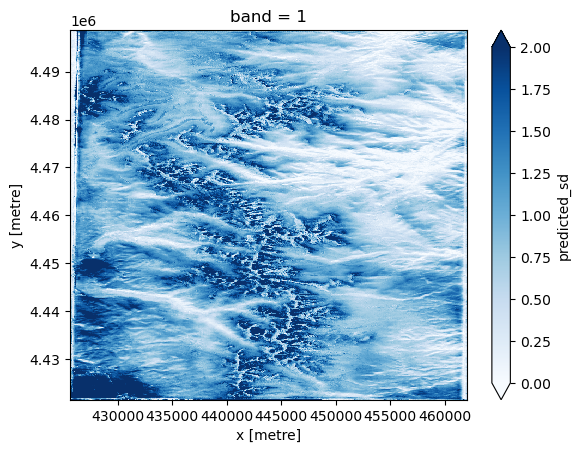

In [10]:
ds['predicted_sd'].plot(cmap='Blues', vmin=0, vmax=2)

In [11]:
ds.predicted_sd.rio.to_raster('../../data/pred_sd.tif')